<a href="https://colab.research.google.com/github/COTILab/MCX24Workshop/blob/master/Training/MCX2024_1D_mcxlab_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![Workshop Logo](https://mcx.space/wiki/upload/mcx24_logo.png)
# MCX Training Workshop 2024 - Day 1, Session 1D

## Session 1D: MCXLAB Training


# <font color='orange'>Step 0: Setting up MCX and Octave environments within Google Colab</font>

> **You must rerun all cells in Step 0 in appearance order when you start a new session, or after reconnect to a runtime**

To run interactive Octave sessions inside a Google Colab Jupyter Notebook environment, we need to install the following dependencies
- GNU Octave via `sudo apt-get install octave`
- Oct2py Python module via `pip install oct2py`, and
- enable Oct2py in Jupyter Notebook via "magic command" `%load_ext oct2py.ipython`

<font color='green'>If you run this on Google Colab, please go to menu **Edit\Notebook Settings\Hardware accelerator**, and verify if it has already selected "GPU"; if not, please select the T4 GPU.</font>

**Please note**: MCX/MCXLAB is GPU-accelerated. This notebook by default requests an NVIDIA GPU. Howevever, when you click on the run-button for the below section, your browser may fail to allocate a GPU runtime and ask you if you want to continue with a non-GPU runtime. If you choose to proceed without GPU support, you will have to run the [section immediately following the next section](#mcx_setup_opencl) to install OpenCL-based MCXLAB (called mcxlabcl) and utilize the CPU to run the rest of the tutorials. The OpenCL version of MCXLAB will work for all examples, but will be substentially slower to run (this tutorial also reduces the photon numbers accordingly to lower the runtime).

In [ ]:
#@title <font color='orange'>Init 1: Initial setup of environment for running MCXLAB (run the below section once)</font>

# install octave and oct2py
! sudo apt-get update && sudo apt-get install octave jq libpocl2 pocl-opencl-icd libnvidia-compute-535   # install octave (a free matlab clone), jq and OpenCL runtimes
! pip install oct2py jdata bjdata matplotlib   # install oct2py, jdata, bjdata and matplotlib Python modules

# add octave support to colab notebook
%load_ext oct2py.ipython

# download and unzip mcxlab
! rm -rf mcxlab*
! wget https://mcx.space/nightly/release/MCX24/MCXStudio-linux-x86_64-nightlybuild.zip  # download MCX suite
! unzip -o MCXStudio-linux-x86_64-nightlybuild.zip && rm -rf MCXStudio-linux-x86_64-nightlybuild.zip # unzip MCX suite

# add executable to the shell's paths
! sudo cp -a $PWD/MCXStudio/MCXSuite/mcx/bin/mcx /usr/local/bin
! sudo cp -a $PWD/MCXStudio/MCXSuite/mcxcl/bin/mcxcl /usr/local/bin
! sudo cp -a $PWD/MCXStudio/MCXSuite/mmc/bin/mmc /usr/local/bin
! cp -a $PWD/MCXStudio/MATLAB/zmat/octave/gnu-linux-x86_64/zipmat.mex $PWD/MCXStudio/MATLAB/zmat/

# if a GPU runtime can not be allocated, run this section to setup OpenCL and MCXLAB-CL
! [[ ! -f `which nvidia-smi` ]] && sudo mv /usr/local/bin/mcxcl /usr/local/bin/mcx
! mcx -L

### <font color='orange'>Init 2: Only need to run this once at the beginning</font>

In [ ]:
%%octave
addpath([pwd filesep 'MCXStudio/MATLAB/mcxlab']);                 % add path to mcxlab
addpath([pwd filesep 'MCXStudio/MCXSuite/mcx' filesep 'utils']);  % add path to mcx helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/mmclab']);                 % add path to mmclab
addpath([pwd filesep 'MCXStudio/MCXSuite/mmc' filesep 'matlab']); % add path to mmc helper functions
addpath([pwd filesep 'MCXStudio/MATLAB/iso2mesh']);               % add path to iso2mesh/jsonlab
addpath([pwd filesep 'MCXStudio/MATLAB/brain2mesh']);             % add path to brain2mesh
addpath([pwd filesep 'MCXStudio/MATLAB/zmat']);                   % add path to zmat for data compression
addpath([pwd filesep 'MCXStudio/MATLAB/hyperspectral_demo']);     % add path to hyperspectral_demo for exec 4

struct_levels_to_print(1);
print_struct_array_contents(0);

if(system('which nvidia-smi'))                   % if this runtime does not have NVIDIA GPU support
    addpath([pwd filesep 'MCXStudio/MATLAB/mcxlabcl']);    % add path to mcxlabcl
    USE_MCXCL=1;                                 % set USE_MCXCL flag in the base workspace
end

### <font color='orange'>Init 3: Verify your environments</font>

---

In [ ]:
%%octave
which mcx
which s2m
which zipmat

mcxlab('gpuinfo')     % use this command to list supported CPU or GPU in octave
unix('mcx -L')        % use -L flag to list GPU in the command line

'mcx' is a function from the file /content/MCXStudio/MATLAB/mcxlab/mcx.mex

's2m' is a function from the file /content/MCXStudio/MATLAB/iso2mesh/s2m.m

'zipmat' is a function from the file /content/MCXStudio/MATLAB/zmat/zipmat.mex

=============================   GPU Information  ================================

Device 1 of 1:		Tesla T4

Compute Capability:	7.5

Global Memory:		15835660288 B

Constant Memory:	65536 B

Shared Memory:		49152 B

Registers:		65536

Clock Speed:		1.59 GHz

Number of SMs:		40

Number of Cores:	2560

Auto-thread:		81920

Auto-block:		64

ans =

  scalar structure containing the fields:

    name = Tesla T4

    id = 1

    devcount = 1

    major = 7

    minor = 5

    globalmem = 1.5836e+10

    constmem = 65536

    sharedmem = 49152

    regcount = 65536

    clock = 1590000

    sm = 40

    core = 2560

    autoblock = 64

    autothread = 81920

    maxgate = 0

=============================   GPU Information  ================================

Device 1 of 1:		Tesla T4

Compute Capability:	7.5

Global Memory:		15835660288 B

Constant Memory:	65536 B

Shared Memory:		49152 B

Registers:		65536

Clock Speed:		1.59 GHz

Number of SMs:		40

Number of Cores:	2560

Auto-thread:		81920

Auto-block:		64

ans = 0

# MCXLAB Primer

MCXLAB is the **MATLAB/Octave wrapper/bindings** to the MCX GPU-based photon simulation codes.

The mex file, `mcx.mex` (or `mcx.mexa64` etc) is basically a dynamic library similar to a .DLL file on Windows (or .so in Linux, or .dylib in MacOS), and is compiled using the identical CUDA/C-code as used to build the command line based MCX. As a result, the simulation is performed nearly identically. Aside from the MATLAB/Octave binding, we also provide the Python binding in the form of a binary Python module called `pmcx`. The idea is the same as MCXLAB, but an dynamic library interface that can be called in Python.

The major difference between mcx executable, MCXLAB, and pmcx is the user input/output handling.

- User inputs:
  - MCX JSON input file -> MATLAB `cfg` struct
  - input volume file -> `cfg.vol`
  - command line options -> `cfg.issavedet`, `cfg.isreflect`, `cfg.isnormalized` ...
- Data outputs: `[flux, detp, vol, seeds, traj]=mcxlab(cfg)`
  - volumetric output (`session.jnii`) -> `flux.data`: first output of mcxlab
  - detected photon output (`session_detp.jdat`) -> `detp.{detid, ppath, ...}`: second output of mcxlab
  - trajectory output (`session_traj.jdat`) -> `traj.{id,p,w0}`: 5h output of mcxlab

Below is a diagram showing the file-based input/output of MCX in the binary mode

![MCX command line IO](https://mcx.space/wiki/upload/mcxlab-mcx_io.svg)


In comparison, here is the diagram showing the input/output of MCXLAB (both input and outputs are in-memory variables)

![MCXLAB IO](https://mcx.space/wiki/upload/mcxlab-io.svg)

The below diagram showing more details of the input/output data fields of the `mcxlab` wrapper function

![MCXLAB input/output](https://mcx.space/wiki/upload/mcxlab-cfg.svg)

A mapping table between JSON-input-file fields, command line flags, and cfg data fields for MCX/MCXCL and MMC can be found below (click on the image to see enlarged image)

<a href="http://mcx.space/wiki/upload/mcx_flags_list.png"><img src="http://mcx.space/wiki/upload/mcx_flags_list.png" width="1600"></a>


## A starter example

---



The first thing to do is to list the usable GPU on your system. You should use `mcxlab('gpuinfo')`. If there is one or more GPU, you should see GPU information printed in the below cell.

In [ ]:
%%octave

gpus = mcxlab('gpuinfo')
gpus.core

Now you can run a simple simulation below

In [ ]:
%%octave
clear cfg

% make sure you terminate each statement by ';' so no excessive printing that could overwhelm the runtime

%% the below fields are minimumally required to define an MCX simulation
cfg.nphoton=1e6;                   % define how many photon packets to simulate

%% define domain in the form of a labeled volume - each voxel is an integer denoting tissue type ID
cfg.vol=uint8(ones(60,60,60));     % define a label-based volume - each voxel has a integer defining the medium type
cfg.vol(20:40, 30:40, 20:30)=2;    % adding an inclusion by setting to a different label

%% the optical properties of the i-th tissue type must be defined in the (i+1)-th row of cfg.prop
cfg.prop=[0 0 1 1;                 % cfg.prop defines the optical properties, one medium per row; first row is for medium label 0 (background)
          0.005 0.2 0 1.37;        % cfg.prop has 4 columns, in the order [mua(1/mm), mus(1/mm), g(anisotropy), n(ref index)]; 2nd row for medium type 1
          0.1, 2, 0.9, 1];         % third row is for medium type 2, and so on

%% a simulation must have source defined, default type is a pencil beam (cfg.srctype='pencil')
cfg.issrcfrom0=1;                  % if this is not defined, cfg.srcpos and cfg.detpos will subtract 1 in x/y/z
cfg.srcpos=[30 30 1];              % source position in voxel-units
cfg.srcdir=[0 0 1];                % source direction (a unitary vector)
cfg.detpos=[30,27,1,1];            % a detector that is 3 mm away from source with a radius 1 mm

%% other key parameters
cfg.tstart=0;                      % define the start time of the simulation (in s)
cfg.tend=5e-9;                     % define the maximum duration of the photon packet (in s)
cfg.tstep=1e-10;                   % this defines 50 time gates, (tend-tstart)/tstep; when tstep=tend, it defines a single time window, producing a CW solution

%% cfg.gpuid specifies which GPU to use, default is the first GPU
cfg.gpuid=1;                       % use the first GPU (default), can use strings of '01' masks to use multiple GPU, such as '0110'

% reduce photon number on runtimes without a GPU (i.e. CPU only)
if(exist('USE_MCXCL', 'var') && USE_MCXCL==1)  % if no GPU is found, run less photon on the CPU
    cfg.nphoton=1e5;               % define how many photon packets to simulate
end

Run the above simulation by calling `mcxlab()`

Running this section for the first time can be slightly slow as CUDA needs to initialize the GPU device. Running again should take less than a second.

In [ ]:
%%octave

flux=mcxlab(cfg);
fieldnames(flux)

size(flux.data)

imagesc(log10(squeeze(flux.data(:,30,:))))
colorbar
axis equal

## A starter+ example

Let's go over the below updated cfg struct. A few additions were made compared to the earlier example

-

In [ ]:
%%octave
clear cfg

% make sure you terminate each statement by ';' so no excessive printing that could overwhelm the runtime

%% the below fields are minimumally required to define an MCX simulation
cfg.nphoton=1e7;                   % define how many photon packets to simulate

%% define domain in the form of a labeled volume - each voxel is an integer denoting tissue type ID
cfg.vol=uint8(zeros(60,60,60));     % define a label-based volume - each voxel has a integer defining the medium type
cfg.vol(2:end-1,2:end-1,2:end-1)=1; % define a label-based volume - each voxel has a integer defining the medium type
cfg.vol(20:40, 30:40, 20:30)=2;    % adding an inclusion by setting to a different label

%% save diffuse reflectanct at z=0 plane - total light escaped from the bottom plane
cfg.issaveref=1;                   % save diffuse reflectance - can only save to the 0-valued voxel next to a boundary

%% the below two settings allow us to verify energy-conservation in MCX
cfg.isnormalized=0;                % disable normalization
cfg.outputtype='energy';           % save energy deposition
cfg.isspecular=0;                  % save energy deposition

%% the optical properties of the i-th tissue type must be defined in the (i+1)-th row of cfg.prop
cfg.prop=[0 0 1 1;                 % cfg.prop defines the optical properties, one medium per row; first row is for medium label 0 (background)
          0.005 0.2 0 1.37;          % cfg.prop has 4 columns, in the order [mua(1/mm), mus(1/mm), g(anisotropy), n(ref index)]; 2nd row for medium type 1
          0.1, 2, 0.9, 1];        % third row is for medium type 2, and so on

%% a simulation must have source defined, default type is a pencil beam (cfg.srctype='pencil')
cfg.issrcfrom0=1;                  % if this is not defined, cfg.srcpos and cfg.detpos will subtract 1 in x/y/z
cfg.srcpos=[30 30 1];              % source position in voxel-units
cfg.srcdir=[0 0 1];                % source direction (a unitary vector)
cfg.detpos=[30,27,1,1];            % a detector that is 3 mm away from source with a radius 1 mm

%% other key parameters
cfg.tstart=0;                      % define the start time of the simulation (in s)
cfg.tend=5e-9;                     % define the maximum duration of the photon packet (in s)
cfg.tstep=1e-10;                   % this defines 50 time gates, (tend-tstart)/tstep; when tstep=tend, it defines a single time window, producing a CW solution

%% cfg.gpuid specifies which GPU to use, default is the first GPU
cfg.gpuid=1;                       % use the first GPU (default), can use strings of '01' masks to use multiple GPU, such as '0110'

% reduce photon number on runtimes without a GPU (i.e. CPU only)
if(exist('USE_MCXCL', 'var') && USE_MCXCL==1)  % if no GPU is found, run less photon on the CPU
    cfg.nphoton=1e5;               % define how many photon packets to simulate
end

Run below cell

In [ ]:
%%octave
% calculate the flux distribution with the given config
flux=mcxlab(cfg);

fieldnames(flux)

% flux.stat records some basic simulation
flux.stat
size(flux.data)

cwfluence=sum(flux.data, 4);
contourf(log10(squeeze(cwfluence(30,:,:))), 30);
axis equal
colorbar
colormap('jet')

%% show (unnormalized) diffuse reflectance at z=0 plane
size(flux.dref)
dref=sum(flux.dref, 4); % sum the 4th dimension, whcih is time-gates, providing the CW solution
figure;
contourf(log10(dref(:,:,1)),20)

%% verify energy deposition
total_absorbed=sum(flux.data(:))
total_escaped=sum(flux.dref(:))
total_launched=total_absorbed + total_escaped

## Exec 1 - Using sources sources and source control

In [ ]:
%%octave
clear cfg

% make sure you terminate each statement by ';' so no excessive printing that could overwhelm the runtime

cfg.nphoton=200;
cfg.tstart=0;
cfg.tend=5e-9;
cfg.tstep=5e-9;

% define the domain using shapes descriptors

cfg.shapes= '{"Shapes":[{"Grid":{"Tag":1,"Size":[40,60,30]}},{"Sphere":{"Tag":2,"O":[20,30,10],"R":10}}]}';
cfg.prop=[0, 0, 1, 1; 0, 0, 1, 1.37; 0, 0.01, 0, 1.37];

cfg.isreflect=0;
cfg.issrcfrom0=1;
cfg.isspecular=0;

% below are the primary options for controlling source behaviors
srctype='disk' # @param ["pencil", "isotropic", "cone", "gaussian", "planar","fourier", "arcsine", "disk", "fourierx", "fourierx2d", "zgaussian", "line", "slit", "pencilarray", "hyperboloid", "ring"]
focallength=10  # @param {type:"raw", note:"nan for isotropic launch, -inf for Lambertian launch, positive for converting, negative for diverging"}
launchweight=1   # @param {type:'number'}
srcpos=[10, 0, 10] # @param {type: "raw"}
srcdir=[0, 1, 0]       # @param {type: "raw"}
srcparam1=[4, 0, 0, 0] # @param {type: "raw"}
srcparam2=[0, 0, 0, 0] # @param {type: "raw"}

cfg.srctype=srctype;
cfg.srcpos=[srcpos,launchweight];
cfg.srcdir=[srcdir,focallength];
cfg.srcparam1=srcparam1;
cfg.srcparam2=srcparam2;


In [ ]:
%%octave

cfg.debuglevel='T';
traj=mcxlab(cfg);

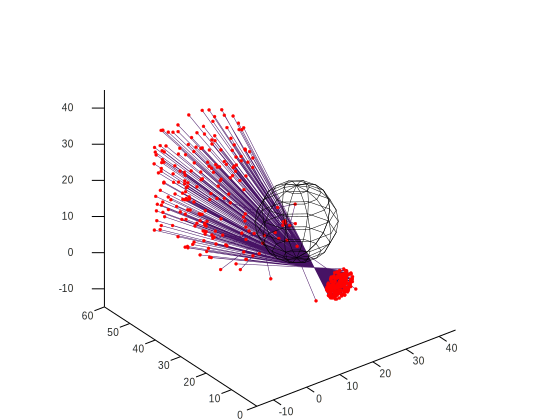

In [ ]:
%%octave -f svg
sortedlines=mcxplotphotons(traj, 'marker','.', 'markersize', 3, 'markeredgecolor', 'r');
axis equal
set(gca, 'position', [0 0 1 1]);
hold on;

shapes=loadjson(cfg.shapes);
[sx,sy,sz]=sphere(10);

R=shapes.Shapes{2}.Sphere.R;
C0=shapes.Shapes{2}.Sphere.O;
surf(sx*R+C0(1), sy*R+C0(2), sz*R+C0(3), 'facecolor', 'none')
set(gca, 'position', [0 0 1 1]);

The above JSON string based shape construct can also be generated by converting a MATLAB/Octave struct object as JSON via JSONLab's `savejson(.., 'compact',1)` function - this makes it easier to edit and the output is always valid JSON

In [ ]:
%%octave

% shape JSON construct fieldname is case-sensitive

Shapes={};  % Shapes is a cell array
Shapes{end+1}=struct('Grid', struct('Tag', 1, 'Size', [40,60,30]));  % add Grid object with label 1
Shapes{end+1}=struct('Sphere', struct('Tag', 2, 'O', [20,30,10], 'R', 10)); % add a sphere with label 2

cfg.shapes=savejson('Shapes', Shapes, 'compact', 1);

cfg.shapes

## Exec 2 - Photon detection and detected photon data processing

----

Another key aspect of MCX simulations is the ability to obtain physical quantities associated with each simulated **photon packet**, especially those arriving at the desired detectors.

Here, the keyword **photon packet** is the key. <font color=orange>MCX **DOES NOT** simulate individual photon</font>. Instead, each simulated "photon" is a packet, made of billions of individual photons. By propagating such packet, some of the photons in the packet are absorbed/disappeared. What's left in the packet is characterized by a floating-point number, called weight. A packet is launched with a unitless weight of 1, and

There are 3 machanisms to obtain detected photon information.

- using disk-shaped detectors, defined via `cfg.detpos=[dx,dy,dz,R]`
- using boundary condition flag `cfg.bc='______111111'` to capture photons escaping from the bounding box, or
- using `cfg.issaveref=1` to enable diffuse reflectance on the selected surface



In [ ]:
%%octave
clear cfg

% make sure you terminate each statement by ';' so no excessive printing that could overwhelm the runtime

cfg.nphoton=1e7;
cfg.tstart=0;
cfg.tend=5e-9;
cfg.tstep=5e-9;

% define the domain using shapes descriptors
cfg.vol=zeros(60,60,60);
cfg.shapes= '{"Shapes":[{"Sphere":{"Tag":1,"O":[30,30,30],"R":30}}]}';
cfg.prop=[0, 0, 1, 1; 0.02, 1, 0, 1.37];

%cfg.shapes= '{"Shapes":[{"Grid":{"Tag":1,"Size":[60,60,60]}},{"Sphere":{"Tag":2,"O":[30,30,30],"R":30}}]}';
%cfg.prop=[0, 0, 1, 1; 0, 0, 1, 1; 0.02, 1, 0, 1.37];

cfg.issrcfrom0=1;
% below are the primary options for controlling source behaviors
cfg.srctype='pencil';
cfg.srcpos=[30,30,0];
cfg.srcdir=[0,0,1];

% mcx detectors captures photons at the "intersecting surface" between tissue-0-voxel boundary and a sphere of given radius
% when multiple detectors have overlapping surface, the lower-index detector takes priority
% this allows us to create ring-like detectors

cfg.detpos=[30,30,60,5      % detector 1: centered on top of the sphere; radius 5
            30,30,60,10     % detector 2: centered on top of the sphere; radius 10
            30,30,60,15     % detector 3: centered on top of the sphere; radius 15
            30,30,60,20];   % detector 4: centered on top of the sphere; radius 20
cfg.bc='______000100';      % also save all photons escaping from x=x_max bounding box face

cfg.savedetflag='dpxv';     % save d: det_id, p: ppath, x: exit position, v: exit direction

Now run the simulation and plot the exiting positions of each captured packet, colored by the detector ID

Launching MCXLAB - Monte Carlo eXtreme for MATLAB & GNU Octave ...

Running simulations for configuration #1 ...

mcx.nphoton=1e+07;

mcx.tstart=0;

mcx.tend=5e-09;

mcx.tstep=5e-09;

mcx.dim=[60 60 60];

mcx.mediabyte=4;

mcx.shapedata='{"Shapes":[{"Sphere":{"Tag":1,"O":[30,30,30],"R":30}}]}';

mcx.medianum=2;

mcx.issrcfrom0=1;

mcx.srctype='pencil';

mcx.srcpos=[30 30 0 1];

mcx.srcdir=[0 0 1 0];

mcx.detnum=4;

mcx.bc='______000100';

mcx.savedetflag=53;

###############################################################################

#                      Monte Carlo eXtreme (MCX) -- CUDA                      #

#          Copyright (c) 2009-2024 Qianqian Fang <q.fang at neu.edu>          #

#                https://mcx.space/  &  https://neurojson.io/                 #

#                                                                             #

# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #

#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #

###############################################################################

#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #

###############################################################################

#  Open-source codes and reusable scientific data are essential for research, #

# MCX proudly developed human-readable JSON-based data formats for easy reuse.#

#                                                                             #

#Please visit our free scientific data sharing portal at https://neurojson.io/#

# and consider sharing your public datasets in standardized JSON/JData format #

###############################################################################

$Rev::f959c7$v2024.6 $Date::2024-06-22 15:23:34 -04$ by $Author::Qianqian Fang$

###############################################################################

- code name: [Jumbo Jolt] compiled by nvcc [9.0] for CUDA-arch [350] on [Jun 22 2024]

- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=1 (Tesla T4) threadph=122 extra=5760 np=10000000 nthread=81920 maxgate=1 repetition=1

initializing streams ...	init complete : 0 ms

requesting 1536 bytes of shared memory

launching MCX simulation for time window [0.00e+00ns 5.00e+00ns] ...

simulation run# 1 ...

kernel complete:  	449 ms

retrieving fields ... 	detected 23750 photons, total: 23750	transfer complete:	461 ms

normalizing raw data ...	source 1, normalization factor alpha=20.000000

data normalization complete : 468 ms

simulated 10000000 photons (10000000) with 81920 threads (repeat x1)

MCX simulation speed: 23696.68 photon/ms

total simulated energy: 10000000.00	absorbed: 41.29900%

(loss due to initial specular reflection is excluded in the total)

ans =

{

  [1,1] = detid

  [2,1] = ppath

  [3,1] = p

  [4,1] = v

  [5,1] = prop

  [6,1] = data

}

ans =

       8   23750

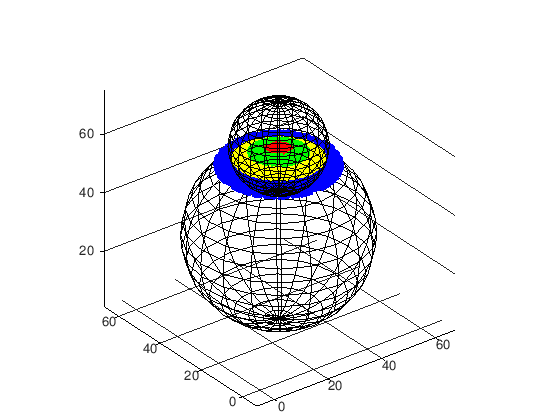

In [ ]:
%%octave
[flux, detp, vol]=mcxlab(cfg);

fieldnames(detp)
size(detp.data)

close all

[sx,sy,sz]=sphere;
surf(sx*29+30, sy*29+30, sz*29+30, 'facecolor', 'none')

hold on;

% all detected photons are located on the spherical object surface
% overlapping detectors are captured by det of the lowerest index

plotmesh(detp.p(detp.detid==1,:), 'r.')
plotmesh(detp.p(detp.detid==2,:), 'g.')
plotmesh(detp.p(detp.detid==3,:), 'y.')
plotmesh(detp.p(detp.detid==4,:), 'b.')
plotmesh(detp.p(detp.detid==-1,:), 'm.')  % packets captured by boundary condition flag have ID of -1

surf(sx*15+30, sy*15+30, sz*15+60, 'facecolor', 'none')

set(gca, 'position', [0 0 1 1]);



Obtaining detected photon data have many applications in biophotonics data processing. For example, the partial pathlength can be used to compute detector measurement by summing the total detected weight.

In [ ]:
%%octave

detw=mcxdetweight(detp);
det1=sum(detw(detp.detid==1))   % detected total weight from detector-1
det2=sum(detw(detp.detid==2))   % detected total weight from detector-2
det3=sum(detw(detp.detid==3))
det4=sum(detw(detp.detid==4))

newprop=detp.prop;
newprop(2,1)=0.03;  % changing medium-1 mua to 0.03/mm from 0.02

detw=mcxdetweight(detp, newprop);
det1=sum(detw(detp.detid==1))
det2=sum(detw(detp.detid==2))
det3=sum(detw(detp.detid==3))
det4=sum(detw(detp.detid==4))

system('ls MCXStudio/MCXSuite/mcx/utils/mcx*.m')
help mcxmeanpath

mcxmeanpath(struct('ppath', detp.ppath(detp.detid==1, :)), detp.prop)
mcxmeanpath(struct('ppath', detp.ppath(detp.detid==3, :)), detp.prop)
mcxmeanpath(struct('ppath', detp.ppath(detp.detid==-1, :)), detp.prop)

## Exec 3 - Improving boundary handling with split-voxel MC (SVMC) - understanding MCX's weaknesses

MCX relies on voxel-based domain dicretization to model 3-D complex media. It has the benefits
- computationally efficient
- arbitrarily complex
- matching medical imaging data structure

However, the stair-case nature of the voxelated boundary shape creates challenges in certain applications
- domain boundary is very coarse that deviates from a curved boundary
- low-scattering media where smoothly varying curve boundary presents drastically different reflection/transmission behavior than stair-case boundary
- tissue shape feature size is much smaller than voxel-size - skin over thick tissue, capilaries inside optically-thick tissues

Such limitations have been significantly addressed with our mesh-based MC (MMC) and implicit MMC (iMMC) algorithms (will cover in another session) - at the cost of slightly more complex data structures (mesh vs voxels), and different ray-tracing computation costs (ray-voxel intersecting test is much simpler than ray-tetrahedron intersecting tests).

Nonetheless, our group had developed an improved voxel-based MC simulation technique, published in the following paper

> Shijie Yan and Qianqian Fang*, ["A hybrid mesh and voxel based Monte Carlo algorithm for accurate and efficient photon transport modeling in complex bio-tissues,"](https://www.osapublishing.org/boe/abstract.cfm?uri=boe-11-11-6262) Biomed. Opt. Express, 11(11) pp. 6262-6270 (2020).

This new technique, named split-voxel MC (SVMC) is essentially a hybrid mesh/voxel based domain that is both memory efficient while is capable of storing oblique surfaces within voxel based data.

![](http://mcx.space/wiki/upload/mcx_svmc_diagram.png)


In [3]:
%%octave
clear cfg

% make sure you terminate each statement by ';' so no excessive printing that could overwhelm the runtime

cfg.nphoton=100;
cfg.tstart=0;
cfg.tend=5e-9;
cfg.tstep=5e-9;

% define the domain using shapes descriptors
cfg.vol=zeros(60,60,60);
cfg.shapes= '{"Shapes":[{"Sphere":{"Tag":1,"O":[30,30,30],"R":15}}]}';
cfg.prop=[0, 0, 1, 1; 0.02, 0, 1, 5];

cfg.issrcfrom0=1;
% below are the primary options for controlling source behaviors
cfg.srctype='disk';
cfg.srcpos=[30,30,0];
cfg.srcdir=[0.2,0,1]/sqrt(1+0.04);
cfg.srcparam1=[1,0,0,0];

Launching MCXLAB - Monte Carlo eXtreme for MATLAB & GNU Octave ...

Running simulations for configuration #1 ...

mcx.nphoton=100;

mcx.tstart=0;

mcx.tend=5e-09;

mcx.tstep=5e-09;

mcx.dim=[60 60 60];

mcx.mediabyte=4;

mcx.shapedata='{"Shapes":[{"Sphere":{"Tag":1,"O":[30,30,30],"R":15}}]}';

mcx.medianum=2;

mcx.issrcfrom0=1;

mcx.srctype='disk';

mcx.srcpos=[30 30 0 1];

mcx.srcdir=[0.196116 0 0.980581 0];

mcx.srcparam1=[1 0 0 0];

mcx.debuglevel=8;

###############################################################################

#                      Monte Carlo eXtreme (MCX) -- CUDA                      #

#          Copyright (c) 2009-2024 Qianqian Fang <q.fang at neu.edu>          #

#                https://mcx.space/  &  https://neurojson.io/                 #

#                                                                             #

# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #

#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #

###############################################################################

#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #

###############################################################################

#  Open-source codes and reusable scientific data are essential for research, #

# MCX proudly developed human-readable JSON-based data formats for easy reuse.#

#                                                                             #

#Please visit our free scientific data sharing portal at https://neurojson.io/#

# and consider sharing your public datasets in standardized JSON/JData format #

###############################################################################

$Rev::f959c7$v2024.6 $Date::2024-06-22 15:23:34 -04$ by $Author::Qianqian Fang$

###############################################################################

- code name: [Jumbo Jolt] compiled by nvcc [9.0] for CUDA-arch [350] on [Jun 22 2024]

- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=1 (Tesla T4) threadph=0 extra=100 np=100 nthread=81920 maxgate=1 repetition=1

initializing streams ...	init complete : 0 ms

requesting 1280 bytes of shared memory

launching MCX simulation for time window [0.00e+00ns 5.00e+00ns] ...

simulation run# 1 ...

kernel complete:  	35 ms

retrieving fields ... 	saved 423 trajectory positions, total: 423	simulated 100 photons (100) with 81920 threads (repeat x1)

MCX simulation speed: 20.00 photon/ms

total simulated energy: 100.00	absorbed: 56.48633%

(loss due to initial specular reflection is excluded in the total)

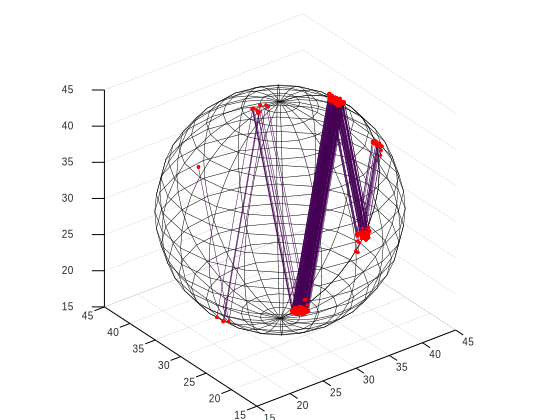

In [4]:
%%octave -f svg

cfg.debuglevel='T';

traj=mcxlab(cfg);

close all

shapes=loadjson(cfg.shapes);
[sx,sy,sz]=sphere;

R=shapes.Shapes.Sphere.R;
C0=shapes.Shapes.Sphere.O;
surf(sx*R+C0(1), sy*R+C0(2), sz*R+C0(3), 'facecolor', 'none')

hold on;
sortedlines=mcxplotphotons(traj, 'marker','.', 'markersize', 3, 'markeredgecolor', 'r');
axis equal
set(gca, 'position', [0 0 1 1]);

Launching MCXLAB - Monte Carlo eXtreme for MATLAB & GNU Octave ...

Running simulations for configuration #1 ...

mcx.nphoton=100;

mcx.tstart=0;

mcx.tend=5e-09;

mcx.tstep=5e-09;

mcx.dim=[60 60 60];

mcx.mediabyte=97;

mcx.medianum=2;

mcx.issrcfrom0=1;

mcx.srctype='disk';

mcx.srcpos=[30 30 0 1];

mcx.srcdir=[0.196116 0 0.980581 0];

mcx.srcparam1=[1 0 0 0];

mcx.debuglevel=8;

###############################################################################

#                      Monte Carlo eXtreme (MCX) -- CUDA                      #

#          Copyright (c) 2009-2024 Qianqian Fang <q.fang at neu.edu>          #

#                https://mcx.space/  &  https://neurojson.io/                 #

#                                                                             #

# Computational Optics & Translational Imaging (COTI) Lab- http://fanglab.org #

#   Department of Bioengineering, Northeastern University, Boston, MA, USA    #

###############################################################################

#    The MCX Project is funded by the NIH/NIGMS under grant R01-GM114365      #

###############################################################################

#  Open-source codes and reusable scientific data are essential for research, #

# MCX proudly developed human-readable JSON-based data formats for easy reuse.#

#                                                                             #

#Please visit our free scientific data sharing portal at https://neurojson.io/#

# and consider sharing your public datasets in standardized JSON/JData format #

###############################################################################

$Rev::f959c7$v2024.6 $Date::2024-06-22 15:23:34 -04$ by $Author::Qianqian Fang$

###############################################################################

- code name: [Jumbo Jolt] compiled by nvcc [9.0] for CUDA-arch [350] on [Jun 22 2024]

- compiled with: RNG [xorshift128+] with Seed Length [4]

GPU=1 (Tesla T4) threadph=0 extra=100 np=100 nthread=81920 maxgate=1 repetition=1

initializing streams ...	init complete : 1 ms

requesting 1280 bytes of shared memory

launching MCX simulation for time window [0.00e+00ns 5.00e+00ns] ...

simulation run# 1 ...

kernel complete:  	28 ms

retrieving fields ... 	saved 201 trajectory positions, total: 201	simulated 100 photons (100) with 81920 threads (repeat x1)

MCX simulation speed: 50.00 photon/ms

total simulated energy: 100.00	absorbed: 36.93984%

(loss due to initial specular reflection is excluded in the total)

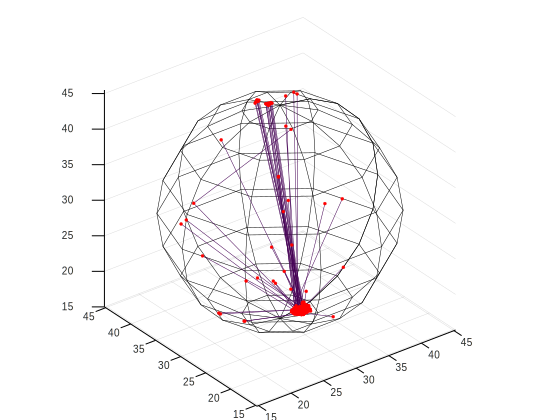

In [ ]:
%%octave -f svg

dims=size(cfg.vol);
[xi, yi, zi] = ndgrid(1:dims(1), 1:dims(2), 1:dims(3));
dist = (xi - 30.5).^2 + (yi - 30.5).^2 + (zi - 30.5).^2;
binvol = zeros(size(xi));
binvol(dist < 15*15) = 1;

cfg_svmc=cfg;

cfg_svmc.vol=mcxsvmc(binvol, 'smoothing', 1); % 1: enable gaussian smoothing 0: otherwise
cfg_svmc.vol=uint8(cfg_svmc.vol);

if(isfield(cfg_svmc, 'shapes'))
    cfg_svmc=rmfield(cfg_svmc, 'shapes');
end

traj_svmc=mcxlab(cfg_svmc);

close all

shapes=loadjson(cfg.shapes);
[sx,sy,sz]=sphere(10);

R=shapes.Shapes.Sphere.R;
C0=shapes.Shapes.Sphere.O;
surf(sx*R+C0(1), sy*R+C0(2), sz*R+C0(3), 'facecolor', 'none');

hold on;
sortedlines=mcxplotphotons(traj_svmc, 'marker','.', 'markersize', 3, 'markeredgecolor', 'r');
axis equal
set(gca, 'position', [0 0 1 1]);

## Exec 4 - Hyperspectral data simulation using `mcxlab` in a layered skin model

#### Prepared and presented by Dr. Steve Jacques

In this exercise, Dr. Steve Jacques will walk you through an example using MCXLAB to simulate a 4-layer skin tissue model with a sweep of optical properties over a range of wavelengths, producing the hyperspectral diffuse reflectance measurements.

In this example, you will also learn
- simulating infinite planar source illuminating an infinitely large layered medium using cyclic boundary conditions
- estimating optical properties at different wavelengths using raw chromophore absorption data
- simulating extended space using optical property scaling
-

In [ ]:
%%octave

% runMCXSpectrum_skin1Dreflectance.m
%   Create total reflectance spectrum (300:10:1000nm)
%   for total diffuse reflectance from infintely broad beam.
%   Skin layers:
%       epidermis
%       papillary dermis
%       vasular plexus
%       reticular dermis (semi-infinite thickness)
%   USES:
%       SpectralLIBMUmm.mat
%       makeTissueList_skin.m
%       mcxlab_exec4_draw.m
%
%%% 17june2024.sljacques

clear cfg label prop
close all

%% load Spectral Absorption Library: nmLIB(701,1), MUY(701,6), msg
%   MU(:,[oxyB deoxyB Water Carotenoids Melanin Fat])
%   oxyB, deoxyB = mu_a of whole blood (~45% hematocrit=150 g.HGb/liter, MW.HGb = 64500g/mole)
%       https://omlc.org/spectra/hemoglobin/summary.html
%   Water = mu_a of pure water
%    	G. M. Hale and M. R. Querry, "Optical constants of water in the 200nm to
%       200-um wavelength region," Appl. Opt., 12, 555--563, (1973).
%   Carotenoids = ( exp(-((nmLIB-476)/45).^2) + 1.5*exp(-((nmLIB-440)/30).^2) )/2.0824
%       such that max of mua_a.carotenoids = 1.0 [1/mm] @446nm.Then scale as needed.
%   Melanin = mu_a of interior of cutaneous melanosome
%       mu_a.melanosome = (67.92/mm)*(nmLIB/500nm).^(-3.33)
%   Fat = mu_a of fat.  Data for pure lipid purified from pig fat.
%     	van Veen R.L.P. , H.J.C.M. Sterenborg, A. Pifferi, A. Torricelli,
%       R. Cubeddu: Determination of VIS- NIR absorption coefficients
%       of mammalian fat, with time- and spatially resolved diffuse
%       reflectance and transmission spectroscopy,
%       OSA Annual BIOMED Topical Meeting, 2004.

load SpectralLIBMUmm.mat
msg
whos nmLIB MU

label(1).s='oxy whole blood';
label(2).s='deoxy whole blood';
label(3).s='water';
label(4).s='carotenoids';
label(5).s='melanosome';
label(6).s='fat';

figure;clf

clr='rbcgkm';
f=2;
for i=1:6
    semilogy(nmLIB,MU(:,i),'-','color',clr(i),'linewidth',2)
    hold on
    text(800,5e-4/f^i,label(i).s,'color',clr(i),'fontsize',12)
end
set(gca,'fontsize',14)
xlabel('Wavelength [nm]')
ylabel('\mu_a [1/mm]')
title('SpectralLIBMUmm.mat')
axis([300 1000 1e-6 1e3])

%%% Wavelength range for simulations
nmm = [300:10:1000]';
Nnm = length(nmm);
MU2 = interp1(nmLIB,MU,nmm); % <--- interpolate properties

%%% volume size and unitinmm
Ny=100; Nx=100; Nz=500;
dxyz = 0.010; % mm

%% % create cfg files
cfg.tstart = 0;
cfg.tend   = 5e-9;
cfg.tstep  = 5e-9;
cfg.isreflect = 1; % enable total internal reflection at exterior boundary
cfg.issaveref = 1; % enable saving escaping light as reflectance

cfg.unitinmm = dxyz; % mm

% a uniform planar source illuminating entire top surface of the volume
% cyclic side boundaries mimic infinitely broad beam
w=Nx;   % width [units]
hw=w/2; % half-width
cfg.srctype     = 'planar';
cfg.srcdir      = [0 0 1]; % incident along z-axis
cfg.srcpos      = [Nx/2-hw Ny/2-hw 0];
cfg.srcparam1   = [w 0 0 0];
cfg.srcparam2   = [0 w 0 0];
cfg.bc='ccrccr'; % cyclic side boundaries

cfg.nphoton     = 1e4; % <---- # of photons per wavelength
%cfg.debuglevel  = 'P';

%% thicknesses of each skin tissue layer
%   epi = epidermis (60 um]
%   pap = papillary dermis (200 um)
%   plx = superficial vascular plexus (200 um)
%   ret = reticular dermis (remaining volume)
d123 = [0.060 0.200 0.200];     % epi pap plx
d4 = (Nz-2)*dxyz - sum(d123);   % ret
d  = [d123 d4];                 % epi pap plx ret [mm]
nd = round(d/dxyz);             % nd(4,1) = dimensionless units of thickness
csd = cumsum(d);

%% Simulation for each wavelength
tic
for inm=1:Nnm
    nm = nmm(inm); % wavelength
    clc
    fprintf('\n\nwavelength = %0.0f nm\n\n',nm)

    % tissue layer properties : epi pap plx ret
    PRINTON=0;
    tissue = makeTissueList_skin(nm, MU2(inm,:), PRINTON);
    prop(1,:)=[0 0 1 1]; % outer boundary [mua mus g n]
    for i=1:4 % i--> epi pap plx ret
        mua = tissue(i).mua;
        mus = tissue(i).mus;
        g   = tissue(i).g;
        n   = tissue(i).n;
        prop(i+1,:) = [mua mus g n];
    end
    prop(6,:) = [mua*1e3 mus*1e3 g n]; % mimic semi-infinite tissue
    cfg.prop = prop;

	  % tissue volume
    % define a 4 layer structure
    % cfg.vol uses 0-->4 (C-code) to point to props(1-->5) (MATLAB)
    cfg.vol = uint8(zeros(Nx,Ny,Nz));        % boundary    0 --> prop(1,:)
    cfg.vol(:,:,1+[1:nd(1)])=1;              % epidermis,  1 --> prop(2,:)
    cfg.vol(:,:,1+nd(1)+[1:nd(2)])=2;        % pap.dermis, 2 --> prop(3,:)
    cfg.vol(:,:,1+sum(nd(1:2))+[1:nd(3)])=3; % plexis,     3 --> prop(4,:)
    cfg.vol(:,:,1+sum(nd(1:3))+[1:nd(4)])=4; % ret.dermis, 4 --> prop(5,:)
    cfg.vol(:,:,Nz-10:Nz-1) = 5; % mimic semi-infinite tissue 5 --> prop(6,:)
    cfg.vol(:,:,Nz) = 1;                     % rear boundary  0 --> prop(1,:)

    flux=mcxlab(cfg);                        % <---- MCX --- RUN SIMULATION

    Rxy       = flux.dref(:,:,1) *cfg.tstep*cfg.unitinmm^2;
    Txy       = flux.dref(:,:,Nz)*cfg.tstep*cfg.unitinmm^2;
    R(inm,1)  = sum( Rxy(:));
    T(inm,1)  = sum( Txy(:));

end % inm
toc


%% show tissue parameters @ 500 nm
inm=find(nmm==500);
PRINTON=1;
fprintf('\nparameters and optical properties @ 500nm\n')
makeTissueList_skin(500,MU2(inm,:),PRINTON);

In [ ]:
%%octave

% plotting the results

close all

%% Show depth-profile of tissue layers
figure;clf
%sz0 = get(0,'screensize')/2;
%pos = round([0.129 0.171 0.7 1.6].*sz0([3 4 3 4]));
%set(figure(1),'position',pos)

fz=12; % fontsize for labels

subplot(211)
plot([1:Nz]',squeeze(cfg.vol(Nx/2,Ny/2,:)),'ro-')
hold on
text(1,.15,'air boundary=0 @ iz=1','fontsize',fz)
for i=1:3
    if i==1 % epidermis
        iz1=2;
    else
        iz1=2+sum(nd(1:i-1));
    end
    z1=dxyz*(iz1-1);
    iz2=1+sum(nd(1:i));
    z2=dxyz*(iz2-1);
    s=sprintf('%s %d%s%d (%0.3f %s %0.3f mm)',...
    tissue(i).name,iz1,'\rightarrow',iz2,...
    z1,'\rightarrow',z2);
    text((3+sum(nd(1:i))),i,s,'fontsize',fz)
end
i=4;
iz1=i+sum(nd(1:i-1));
z1=dxyz*(iz1-1);
iz2=i-3+sum(nd(1:i));
z2=dxyz*(iz2);
s=sprintf('%s %d%s%d (%0.3f %s %0.3f mm)',...
tissue(i).name,iz1,'\rightarrow',iz2,...
z1,'\rightarrow',z2);
text(35,i-.2,s,'fontsize',fz)

xlabel('depth pointer, iz')
ylabel('tissue type')
set(gca,'fontsize',16)
axis([0 100 0 5])

%% Show side-view of tissue layers
subplot(212)

Vzx=squeeze(cfg.vol(:,Ny/2,:))';
imagesc([1:Nx]*dxyz,[1:Nz]*dxyz,Vzx)
hold on
text(0.05,0.045,'epidermis','fontsize',14,'color','w')
text(0.05,.15,'papillary dermis','fontsize',14)
text(0.05,0.34,'vascular plexus','fontsize',14)
text(0.05,0.6,'reticular dermis','fontsize',14)

colorbar
axis([dxyz 1 dxyz 1])

%% Plot R,T spectra
figure;clf
%sz0 = get(0,'screensize')/2;
%pos = round([0.918 0.171 0.700 1.6].*sz0([3 4 3 4]));
%set(figure(2),'position',pos)

subplot(211)

imagesc(Rxy)
axis equal
xlabel('x [mm]')
ylabel('y [mm]')
title('R(y,x) [mm^{-2}]')
colorbar

subplot(212)
plot(nmm,R,'ro-','linewidth',2)
hold on
plot(nmm,T,'bo-','linewidth',2)
xlabel('Wavelength')
ylabel('R_d, T_t')
title('skin: epi,pap,plx,ret','fontweight','normal')
set(gca,'fontsize',16)
axis([300 1000 0 1])

## Exec 5 - Solving inverse problem using MCX